In [1]:
#Predicting the next 10 days

In [2]:
# Load libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import math
import datetime as dt

from numpy import array
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score,r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [3]:
# Load the data into a Pandas DataFrame
bt = pd.read_csv(
    "crypto project/Bitcoin Historical Data (2014-2024).csv")

# Display sample data
bt.head(10)



,Date,Price,Open,High,Low,Vol.,Change %
0,03/24/2024,"67,211.9","64,036.5","67,587.8","63,812.9",65.59K,4.96%
1,03/23/2024,"64,037.8","63,785.6","65,972.4","63,074.9",35.11K,0.40%
2,03/22/2024,"63,785.5","65,501.5","66,633.3","62,328.3",72.43K,-2.62%
3,03/21/2024,"65,503.8","67,860.0","68,161.7","64,616.1",75.26K,-3.46%
4,03/20/2024,"67,854.0","62,046.8","68,029.5","60,850.9",133.53K,9.35%
5,03/19/2024,"62,050.0","67,594.1","68,099.6","61,560.6",148.08K,-8.20%
6,03/18/2024,"67,594.1","68,389.7","68,920.1","66,601.4",78.07K,-1.17%
7,03/17/2024,"68,391.2","65,314.2","68,857.7","64,605.5",66.07K,4.71%
8,03/16/2024,"65,314.2","69,456.5","70,037.0","64,971.0",75.82K,-5.97%
9,03/15/2024,"69,463.7","71,387.1","72,398.1","65,765.6",148.59K,-2.69%


In [4]:
# Convert the date column to datetime format if it's not already in datetime
bt['Date'] = pd.to_datetime(bt['Date'], format='%m/%d/%Y')

# Using the year 2023 to do the analysis
bt_2023 = bt.loc[(bt['Date']>= '2023-01-01') 
             & (bt['Date'] <= '2023-12-31')]

# Print the sorted DataFrame
bt_2023.shape

(365, 7)

In [5]:
#Columns information
bt_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 84 to 448
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      365 non-null    datetime64[ns]
 1   Price     365 non-null    object        
 2   Open      365 non-null    object        
 3   High      365 non-null    object        
 4   Low       365 non-null    object        
 5   Vol.      365 non-null    object        
 6   Change %  365 non-null    object        
dtypes: datetime64[ns](1), object(6)
memory usage: 22.8+ KB


In [6]:
# How many samples do we have?
len(bt_2023)

365

In [7]:
#Changing the column type
bt_2023[["Price", "Open"]] = bt_2023[["Price", "Open"]].applymap(lambda x: float(x.replace(',', '')))

C:\Users\rtkam\AppData\Local\Temp\ipykernel_21972\4115720631.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  bt_2023[["Price", "Open"]] = bt_2023[["Price", "Open"]].applymap(lambda x: float(x.replace(',', '')))
C:\Users\rtkam\AppData\Local\Temp\ipykernel_21972\4115720631.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bt_2023[["Price", "Open"]] = bt_2023[["Price", "Open"]].applymap(lambda x: float(x.replace(',', '')))


In [8]:
#look monthly
bt_2023_monthly= bt_2023.groupby(bt_2023["Date"].dt.strftime("%B"))[['Price', 'Open']].mean()
new_order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
           'September', 'October', 'November', 'December']
bt_2023_monthly= bt_2023_monthly.reindex(new_order, axis=0)
bt_2023_monthly

,Price,Open
Date,,
January,20242.125806,20029.019355
February,23292.742857,23292.403571
March,25079.564516,24907.267742
April,28842.470000,28816.560000
May,27489.090323,27554.693548
June,27758.550000,27649.873333
July,30056.380645,30096.474194
August,27866.067742,27972.464516
September,26307.326667,26273.046667


In [9]:
#Chart showing the monthly average of the open price and close price
fig= go.Figure()

fig.add_trace(go.Bar(
    x=bt_2023_monthly.index,
    y=bt_2023_monthly['Open'],
    name= "Bitcoin Open Price",
    marker_color= 'crimson'
))
fig.add_trace(go.Bar(
    x=bt_2023_monthly.index,
    y=bt_2023_monthly['Price'],
    name= 'Bitcoin Close Price',
    marker_color= 'lightsalmon'
))

fig.update_layout(barmode='group', xaxis_tickangle=45,
                  title= 'Monthly Average of the Open and Close Price')

fig.show()

In [10]:
#Show the highest price and lowest price
bt_2023.groupby(bt_2023['Date'].dt.strftime('%B'))['Low'].min()
monthly_high= bt_2023.groupby(bt_2023['Date'].dt.strftime('%B'))['High'].max()
monthly_high= monthly_high.reindex(new_order, axis=0)

monthly_low= bt_2023.groupby(bt_2023['Date'].dt.strftime('%B'))['Low'].min()
monthly_low= monthly_low.reindex(new_order, axis=0)

#Plotting the results

fig= go.Figure()
fig.add_trace(go.Bar(
    x=monthly_high.index,
    y=monthly_high,
    name= 'Bitcoin high Price',
    marker_color='rgb(0, 153, 204)'
))
fig.add_trace(go.Bar(
    x=monthly_low.index,
    y=monthly_low,
    name='Bitcoin low Price',
    marker_color='rgb(255, 128, 0)'
))

fig.update_layout(title='Monthly High and Low Bitcoin Price')

fig.show()


In [11]:
# Only want Date and Price columns for each day 

bitcoin_prices = bt_2023[["Date", "Price"]]
bitcoin_prices.shape


(365, 2)

In [12]:
fig= px.line(bitcoin_prices, x=bitcoin_prices.Date, y=bitcoin_prices.Price, labels= {'Date': 'Date', 'Price' : 'Close'})
fig.update_traces(marker_line_width= 2, opacity= 0.8, marker_line_color= 'orange')
fig.update_layout(title_text= 'Whole time frame of Bitcoin Close Price 2023', font_size=15, font_color='black')
fig.show()

In [13]:
bitcoin_prices = bitcoin_prices.sort_values(by='Date', ascending=True)
bitcoin_prices

,Date,Price
448,2023-01-01,16618.4
447,2023-01-02,16674.3
446,2023-01-03,16674.2
445,2023-01-04,16852.1
444,2023-01-05,16829.8
...,...,...
88,2023-12-27,43446.5
87,2023-12-28,42581.1
86,2023-12-29,42072.4
85,2023-12-30,42136.7


In [14]:
#Deleting the date column and normalizing the data using MinMAx Scaler
close_stock= bitcoin_prices.copy()
del bitcoin_prices['Date']
scaler = MinMaxScaler(feature_range=(0,1))
bitcoin_prices = scaler.fit_transform(np.array(bitcoin_prices).reshape(-1,1))
print(bitcoin_prices.shape)

(365, 1)


In [15]:
#Splitting the data set into train and test split
training_size = int(len(bitcoin_prices)*0.6)
test_size = len(bitcoin_prices)- training_size

train_data, test_data = bitcoin_prices[0:training_size,:], bitcoin_prices[training_size:len(bitcoin_prices),:1]
print("train_data", train_data.shape)
print("test_data", test_data.shape)


train_data (219, 1)
test_data (146, 1)


In [16]:
#Convert an array of values into a dataset matrix

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range (len(dataset) - time_step -1):
        a = dataset[i:(i + time_step), 0] #i=0, 0, 1, 2, 3
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [17]:
#reshape into X=t, t+1, t+2, t+3 and y=t+4
time_step = 15
X_train, y_train= create_dataset(train_data, time_step)
X_test, y_test= create_dataset(test_data, time_step)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test', y_test.shape)

X_train: (203, 15)
y_train: (203,)
X_test: (130, 15)
y_test (130,)


In [18]:
#Reshape the data to be samples, time steps, features whisch is required for LSTM
X_train= X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

print("X_train:",  X_train.shape)
print("X_test:", X_test.shape)

X_train: (203, 15, 1)
X_test: (130, 15, 1)


In [19]:
#####LSTM 
##Long short-term memory is an artificial recurrent neural network architeture used in the fiel of deep learning.
##Unlike standard feedforward neural networks, LSTM has feedback

In [20]:
#Create the LSTM model
model = Sequential()
model.add(LSTM(10, input_shape=(None,1), activation= 'relu'))
#model.add(LSTM(250, return_sequences= True))
#model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')#, metrics=['accuracy'])


c:\Users\rtkam\anaconda3\envs\dev\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
history= model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=32, verbose=1)

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1860 - val_loss: 0.5017
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1710 - val_loss: 0.4777
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1555 - val_loss: 0.4563
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1549 - val_loss: 0.4370
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1353 - val_loss: 0.4180
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1259 - val_loss: 0.3931
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1112 - val_loss: 0.3586
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0959 - val_loss: 0.3201
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0799 - val_loss: 0.2764
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0634 - val_loss: 0.2262
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0451 - val_loss: 0.1673
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0271 - val_loss: 0.1021


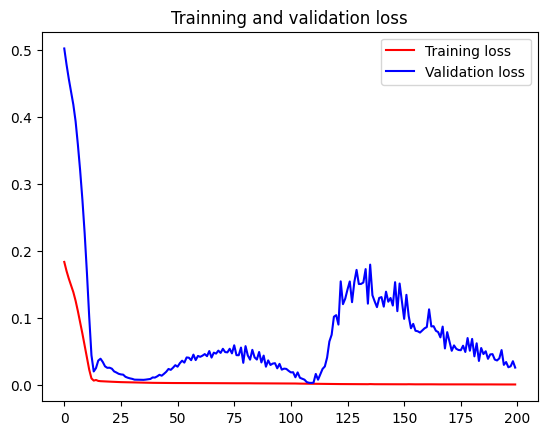

<Figure size 640x480 with 0 Axes>

In [23]:
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs= range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label= 'Validation loss')
plt.title('Trainning and validation loss')
plt.legend(loc=0)
plt.figure()

plt.show()


In [24]:
#Do the prediction and check performande metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


((203, 1), (130, 1))

In [25]:
#Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
original_y_train= scaler.inverse_transform(y_train.reshape(-1,1))
original_y_test= scaler.inverse_transform(y_test.reshape(-1,1))

In [26]:
#Evaluate metrics RMSE, MSE and MAE

print('Train data RMSE:', math.sqrt(mean_squared_error(original_y_train, train_predict)))
print('Train data MSE:', mean_squared_error(original_y_train, train_predict))
print('Train data MAE', mean_absolute_error(original_y_train, train_predict))
print('--------------------------------------------------------------------------------------')
print("Test data RMSE:", math.sqrt(mean_squared_error(original_y_test, test_predict)))
print("Test data MSE:", mean_squared_error(original_y_test, test_predict))
print("Test data MAE:", mean_absolute_error(original_y_test, test_predict))

Train data RMSE: 810.0772229506177
Train data MSE: 656225.1071433848
Train data MAE 607.8972329125615
--------------------------------------------------------------------------------------
Test data RMSE: 4446.57355891198
Test data MSE: 19772016.414815154
Test data MAE: 2314.602833533653


In [27]:
#R square score for regression

print("Train data R2 score:", r2_score(original_y_train, train_predict))
print("Test data R2 score:", r2_score(original_y_test, test_predict))

Train data R2 score: 0.9223632256673711
Test data R2 score: 0.5359267385324096


In [28]:
#Comparision of original stock price and predicted price

look_back=time_step
trainPredictPlot= np.empty_like(bitcoin_prices)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back: len(train_predict)+look_back,]= train_predict
print("Test predicted data:", trainPredictPlot.shape)

testPredictPlot= np.empty_like(bitcoin_prices)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1: len(bitcoin_prices)-1,:]= test_predict
print("Test predicted data:", testPredictPlot.shape)

names= cycle(['Original Price', 'Train predicted Price', 'Test predicted Price'])

plot_df= pd.DataFrame({'date': close_stock['Date'],
                        'original_price':close_stock['Price'],
                        'train_predict_price': trainPredictPlot.flatten(),
                        'test_predicted_price': testPredictPlot.flatten()})

fig= px.line(plot_df, x=plot_df['date'], y=[plot_df['original_price'], plot_df['train_predict_price'], plot_df['test_predicted_price']],
            labels={'value':'Bitcoin Price', 'date': 'Date'})
fig.update_layout(title_text= 'Comparision between original price vc predicted price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text= 'Price')
fig.for_each_trace(lambda t: t.update(name= next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()



Test predicted data: (365, 1)
Test predicted data: (365, 1)


In [35]:
# Prediction for the next 10 days
X_input = test_data[len(test_data) - time_step:].reshape(1, -1)
temp_input = list(X_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = time_step
i = 0
pred_days = 10

while i < pred_days:

    if len(temp_input) > time_step:
        X_input = np.array(temp_input[1:])
        X_input = X_input.reshape(1, -1)
        X_input = X_input.reshape((1, n_steps, 1))

        yhat = model.predict(X_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]

        lst_output.extend(yhat.tolist())
        i = i + 1

    else:
        # Corrected the assignment operator here
        X_input = X_input.reshape((1, n_steps, 1))
        yhat = model.predict(X_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i = i + 1

print("Output of predicted next days:", len(lst_output))







Output of predicted next days: 10


In [36]:
#Plotting whole data with the 10 days prediction
bitcoin_prices_plot= bitcoin_prices.tolist()
bitcoin_prices_plot.extend((np.array(lst_output).reshape(-1,1)).tolist())
bitcoin_prices_plot=scaler.inverse_transform(bitcoin_prices_plot).reshape(1,-1).tolist()[0]

names= cycle(['Price'])

fig=px.line(bitcoin_prices_plot, labels={'value': 'Bitcoin Price', 'index':'Timestamp'})
fig.update_layout(title_text= 'Plotting whole closing stock price with 10 days prediction',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Price')

fig.for_each_trace(lambda t: t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()


In [37]:
predictions=scaler.inverse_transform(lst_output).reshape(1,-1).tolist()[0]
predictions

[28048.18875600398,
 17218.64915230088,
 835.3788904607322,
 -21961.06629401445,
 -46521.40433459281,
 -62294.578469848624,
 -61005.61199994086,
 -50493.373177337635,
 -42682.02717692851,
 -36973.531689679614]